# Credit Card Fraud Detection - EDA & Feature Engineering
Complete exploratory analysis and feature creation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import optuna
import shap
import pickle
from shap import Explanation

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


c:\Users\hkdtu\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = pd.read_csv('creditcard.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
df.shape

(1296675, 23)

In [4]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [6]:
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [7]:
drop_columns = ['Unnamed: 0', 'first', 'last', 'street', 'trans_num']

df.drop(columns=drop_columns, inplace=True, errors='ignore')

In [8]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [9]:
df.shape

(1296675, 18)

In [10]:
df['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [11]:
df['is_fraud'].value_counts(normalize=True) * 100

is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64

In [12]:
# Time Features

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time']) 


df['hour'] = df['trans_date_trans_time'].dt.hour
df['dayofweek'] = df['trans_date_trans_time'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)


In [13]:
df.groupby('hour')['is_fraud'].count().sort_values(ascending=False)


hour
23    67104
22    66982
18    66051
16    65726
21    65533
19    65508
17    65450
15    65391
13    65314
12    65257
20    65098
14    64885
1     42869
3     42769
2     42656
8     42505
0     42502
6     42300
10    42271
7     42203
9     42185
5     42171
11    42082
4     41863
Name: is_fraud, dtype: int64

In [14]:
df.groupby('dayofweek')['is_fraud'].count().sort_values(ascending=False)

dayofweek
0    254282
6    250579
5    200957
1    160227
4    152272
3    147285
2    131073
Name: is_fraud, dtype: int64

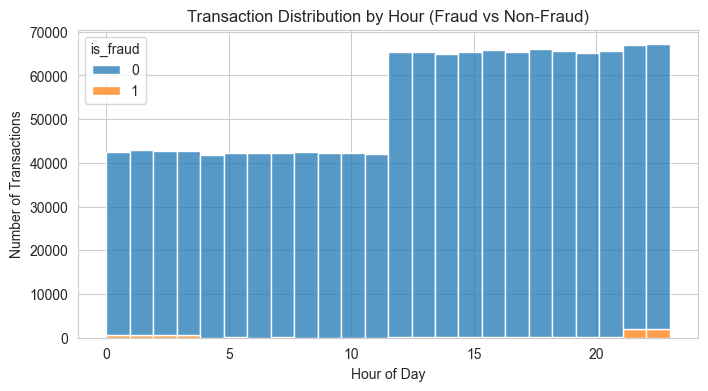

In [15]:
plt.figure(figsize=(8,4))

sns.histplot(data=df, x='hour', hue='is_fraud', multiple='stack', bins=24)

plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.title('Transaction Distribution by Hour (Fraud vs Non-Fraud)')
plt.show()

#Fraud is happening in between 11PM to 4AM range

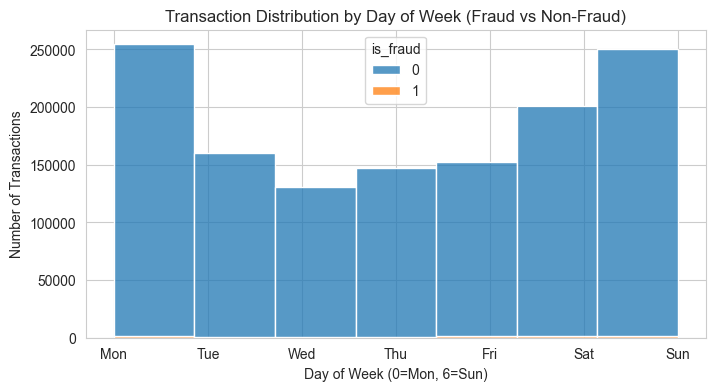

In [16]:
plt.figure(figsize=(8,4))

sns.histplot(data=df, x='dayofweek', hue='is_fraud', multiple='stack', bins=7)

plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Number of Transactions')
plt.title('Transaction Distribution by Day of Week (Fraud vs Non-Fraud)')
plt.show()


In [17]:
df.groupby('is_fraud')['amt'].describe()


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,67.667110,154.007971,1.00,9.6100,47.280,82.540,28948.90
1,7506.0,531.320092,390.560070,1.06,245.6625,396.505,900.875,1376.04


In [18]:

fraud_by_category = df.groupby('category')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
fraud_by_category['fraud_count'] = fraud_by_category['sum']
fraud_by_category['fraud_rate'] = fraud_by_category['mean']
fraud_by_category

,sum,count,mean,fraud_count,fraud_rate
category,,,,,
shopping_net,1713,97543,0.017561,1713,0.017561
misc_net,915,63287,0.014458,915,0.014458
grocery_pos,1743,123638,0.014098,1743,0.014098
shopping_pos,843,116672,0.007225,843,0.007225
gas_transport,618,131659,0.004694,618,0.004694
misc_pos,250,79655,0.003139,250,0.003139
grocery_net,134,45452,0.002948,134,0.002948
travel,116,40507,0.002864,116,0.002864
entertainment,233,94014,0.002478,233,0.002478


In [19]:
# Category analysis
fraud_by_category = df.groupby('category')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
fraud_by_category['fraud_count'] = fraud_by_category['sum']
fraud_by_category['fraud_rate'] = fraud_by_category['mean']

print("Top Categories by Fraud Rate:")
print(fraud_by_category[['fraud_count', 'fraud_rate']].head(10))


Top Categories by Fraud Rate:
               fraud_count  fraud_rate
category                              
shopping_net          1713    0.017561
misc_net               915    0.014458
grocery_pos           1743    0.014098
shopping_pos           843    0.007225
gas_transport          618    0.004694
misc_pos               250    0.003139
grocery_net            134    0.002948
travel                 116    0.002864
entertainment          233    0.002478
personal_care          220    0.002424


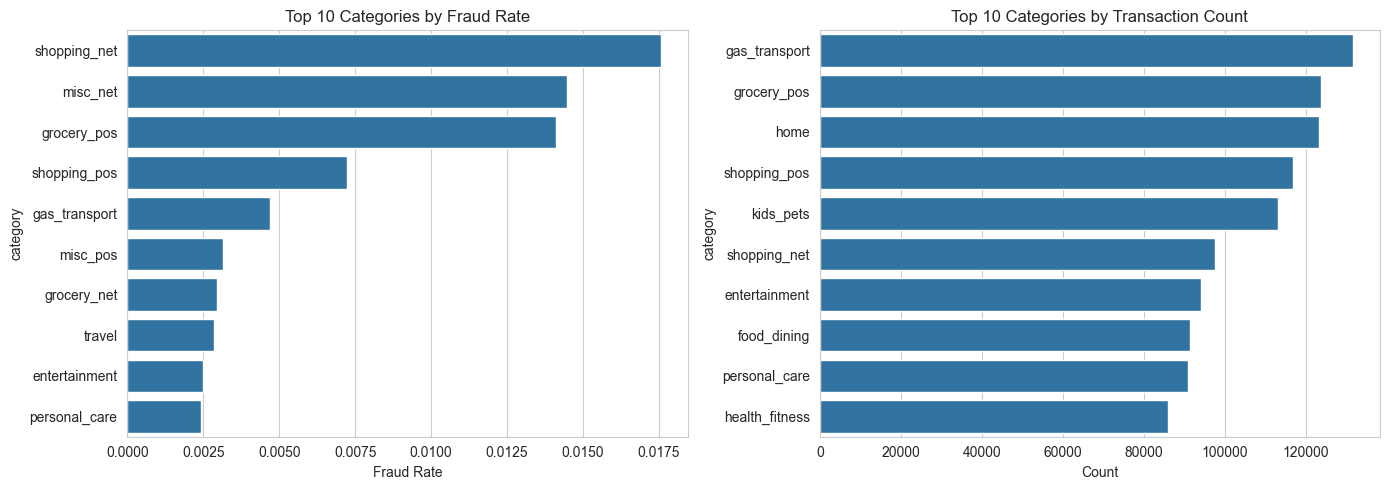

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Top 10 risky categories
top_risk = fraud_by_category.sort_values('fraud_rate', ascending=False).head(10)
sns.barplot(data=top_risk, x='fraud_rate', y=top_risk.index, ax=axes[0])
axes[0].set_title('Top 10 Categories by Fraud Rate')
axes[0].set_xlabel('Fraud Rate')

# Top 10 frequent categories
top_count = df['category'].value_counts().head(10)
sns.barplot(x=top_count.values, y=top_count.index, ax=axes[1])
axes[1].set_title('Top 10 Categories by Transaction Count')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

In [21]:
# df2 = df[['amt']].copy()
# df2['amt_log'] = np.log1p(df2['amt'])

# fig, axes = plt.subplots(1, 2, figsize=(12,4))

# # Before log transform
# sns.histplot(df2['amt'], bins=50, ax=axes[0])
# axes[0].set_title('Original Transaction Amount Distribution')

# # After log transform
# sns.histplot(df2['amt_log'], bins=50, ax=axes[1])
# axes[1].set_title('Log Transformed Amount Distribution')

# plt.tight_layout()
# plt.show()



Log transformation reduces skewness, stabilizes variance, and compresses extreme values, making numerical features easier for machine learning models to learn from

In [22]:
# Amount Features

df['amt_log'] = np.log1p(df['amt'])

# User relative amount deviation

df['user_amt_mean'] = df.groupby('cc_num')['amt'].transform('mean')
df['user_amt_std'] = df.groupby('cc_num')['amt'].transform('std')

df['amt_zscore'] = (
    (df['amt'] - df['user_amt_mean']) /
    df['user_amt_std']
).fillna(0)


| Z-score range | Meaning                | Fraud Interpretation   |
| ------------- | ---------------------- | ---------------------- |
| **0 – 1**     | Normal                 | Normal spending        |
| **1 – 2**     | Slightly unusual       | Mild risk              |
| **2 – 3**     | **Highly unusual**     | **Suspicious**         |
| **> 3**       | **Extremely abnormal** | **High fraud risk**    |


In [23]:
# Velocity Features (How many seconds passed since the previous transaction for this same card?)

df = df.sort_values(['cc_num', 'unix_time'])

df['time_since_last_txn'] = (
    df.groupby('cc_num')['unix_time']
    .diff()
    .fillna(999999)
)



In [24]:
df['txns_last_1hr'] = (df['time_since_last_txn'] < 3600).astype(int)
df['txns_last_10min'] = (df['time_since_last_txn'] < 600).astype(int)


In [25]:
# Geographic Features

# Syntax: geodesic((lat1, lon1), (lat2, lon2)) needs tuple

lat1 = np.radians(df['lat'].values)
lon1 = np.radians(df['long'].values)
lat2 = np.radians(df['merch_lat'].values)
lon2 = np.radians(df['merch_long'].values)

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))

R = 6371  # Earth radius in km
df['geo_distance'] = R * c


In [26]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'hour',
       'dayofweek', 'is_weekend', 'amt_log', 'user_amt_mean', 'user_amt_std',
       'amt_zscore', 'time_since_last_txn', 'txns_last_1hr', 'txns_last_10min',
       'geo_distance'],
      dtype='object')

Cleaning and Encoding

In [27]:
drop_columns = [
    'trans_date_trans_time',
    'unix_time',
    'dob',
    'cc_num',
    'zip',
    'lat', 'long',
    'merch_lat', 'merch_long',
    'amt'   
]

df = df.drop(columns=drop_columns)


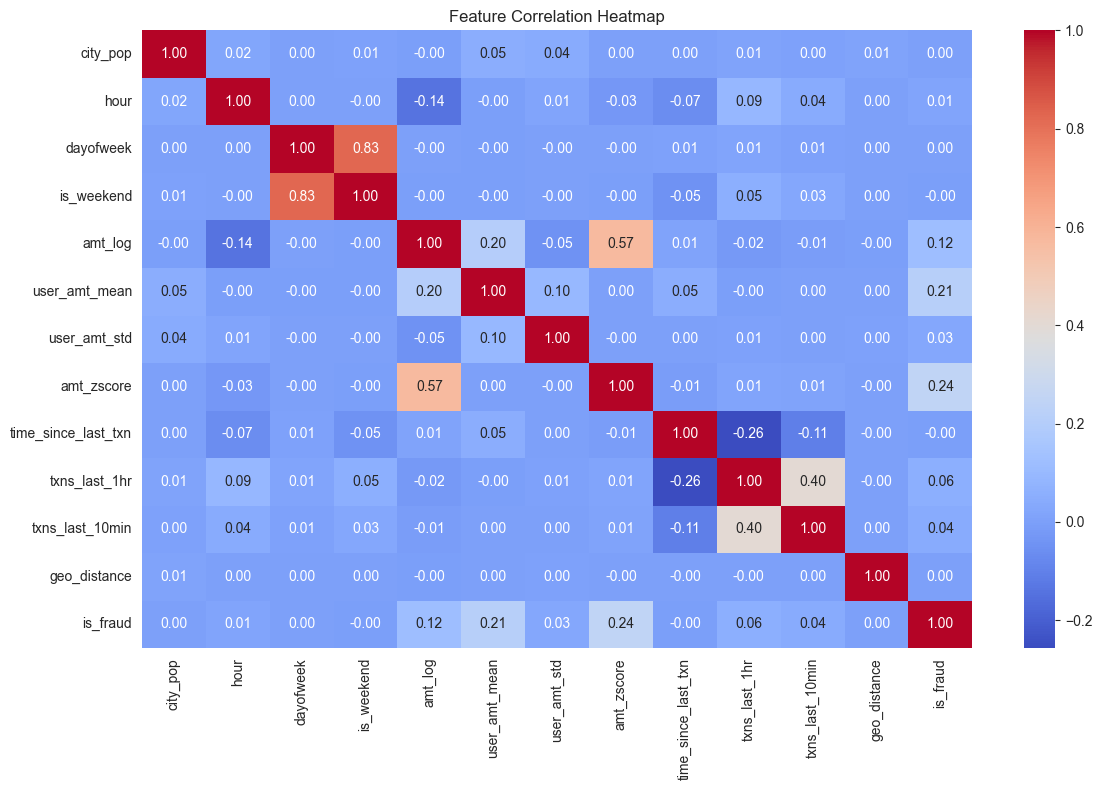

In [28]:
heatmap_cols = [
    'city_pop', 'hour', 'dayofweek', 'is_weekend',
    'amt_log', 'user_amt_mean', 'user_amt_std', 'amt_zscore',
    'time_since_last_txn', 'txns_last_1hr', 'txns_last_10min',
    'geo_distance', 'is_fraud'
]

corr = df[heatmap_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [29]:
# Frequency Encoding 

freq_cols = ['merchant', 'city', 'job', 'state', 'category']

for col in freq_cols:
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

df = df.drop(columns=freq_cols)


In [30]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

print("X shape before preprocessing:", X.shape)


X shape before preprocessing: (1296675, 18)


In [31]:
X.head()

,gender,city_pop,hour,dayofweek,is_weekend,amt_log,user_amt_mean,user_amt_std,amt_zscore,time_since_last_txn,txns_last_1hr,txns_last_10min,geo_distance,merchant_freq,city_freq,job_freq,state_freq,category_freq
1017,F,1645,12,1,0,2.112635,56.023366,122.632635,-0.397556,999999.0,0,0,127.606239,0.000979,0.00272,0.001559,0.014901,0.048807
2724,F,1645,8,2,0,3.987872,56.023366,122.632635,-0.025143,71862.0,0,0,110.308921,0.002065,0.00272,0.001559,0.014901,0.101536
2726,F,1645,8,2,0,4.419804,56.023366,122.632635,0.212477,159.0,1,1,21.787261,0.002028,0.00272,0.001559,0.014901,0.101536
2882,F,1645,12,2,0,3.577669,56.023366,122.632635,-0.173146,13838.0,0,0,87.204215,0.001720,0.00272,0.001559,0.014901,0.087173
2907,F,1645,13,2,0,3.338613,56.023366,122.632635,-0.235201,1952.0,1,0,74.212965,0.001907,0.00272,0.001559,0.014901,0.094947


In [32]:
# Numerical features (scaled)
num_features = [
    'amt_log',
    'user_amt_mean',
    'user_amt_std',
    'amt_zscore',
    'time_since_last_txn',
    'geo_distance',
    'city_pop'
]

# Binary / ordinal features (no scaling)
passthrough_features = [
    'hour',
    'dayofweek',
    'is_weekend',
    'txns_last_1hr',
    'txns_last_10min'
]

# Frequency encoded features
freq_features = [
    'merchant_freq',
    'city_freq',
    'job_freq',
    'state_freq',
    'category_freq'
]

# One-hot encoded features
onehot_features = ['gender']


In [33]:
#syntax (name, transformer, column_list)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('bin', 'passthrough', passthrough_features),
        ('freq', 'passthrough', freq_features),
        ('gender', OneHotEncoder(drop='first', sparse_output=False), onehot_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [34]:
X_processed = preprocessor.fit_transform(X)

print("X shape after preprocessing:", X_processed.shape)


X shape after preprocessing: (1296675, 18)


In [35]:
feature_names = preprocessor.get_feature_names_out()

data = pd.DataFrame(
    X_processed,
    columns=feature_names,
    index=X.index   # keeps row alignment
)

data.head()

,amt_log,user_amt_mean,user_amt_std,amt_zscore,time_since_last_txn,geo_distance,city_pop,hour,dayofweek,is_weekend,txns_last_1hr,txns_last_10min,merchant_freq,city_freq,job_freq,state_freq,category_freq,gender_M
1017,-0.856027,-0.386567,0.005519,-0.445991,28.644345,1.143766,-0.041409,12.0,1.0,0.0,0.0,0.0,0.000979,0.00272,0.001559,0.014901,0.048807,0.0
2724,0.051234,-0.386567,0.005519,0.315576,1.609391,0.743071,-0.041409,8.0,2.0,0.0,0.0,0.0,0.002065,0.00272,0.001559,0.014901,0.101536,0.0
2726,0.260207,-0.386567,0.005519,0.801498,-0.479188,-1.307543,-0.041409,8.0,2.0,0.0,1.0,1.0,0.002028,0.00272,0.001559,0.014901,0.101536,0.0
2882,-0.147227,-0.386567,0.005519,0.012917,-0.080743,0.207848,-0.041409,12.0,2.0,0.0,0.0,0.0,0.001720,0.00272,0.001559,0.014901,0.087173,0.0
2907,-0.262885,-0.386567,0.005519,-0.113983,-0.426961,-0.093096,-0.041409,13.0,2.0,0.0,1.0,0.0,0.001907,0.00272,0.001559,0.014901,0.094947,0.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# for handling class imbalance in model itself
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight


np.float64(173.13798892059762)

In [38]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)

In [39]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [40]:
pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num', RobustScaler(),
                                  ['amt_log', 'user_amt_mean', 'user_amt_std',
                                   'amt_zscore', 'time_since_last_txn',
                                   'geo_distance', 'city_pop']),
                                 ('bin', 'passthrough',
                                  ['hour', 'dayofweek', 'is_weekend',
                                   'txns_last_1hr', 'txns_last_10min']),
                                 ('freq', 'passthrough',
                                  ['merchant_freq', 'city_freq', 'job_freq',
                                   'state_freq', 'category_freq']),
                                 ('gender',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False),
                                  ['gender'])],
                   verbose_feature_names_out=False),
 'model': XGBClassifier(base_scor

In [41]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv)
print("CV AUC:", cv_auc.mean())


CV AUC: 0.9984493904599976


In [42]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

  Legitimate       1.00      0.99      1.00    257786
       Fraud       0.38      0.97      0.55      1549

    accuracy                           0.99    259335
   macro avg       0.69      0.98      0.77    259335
weighted avg       1.00      0.99      0.99    259335

Test ROC AUC: 0.9983417190963321


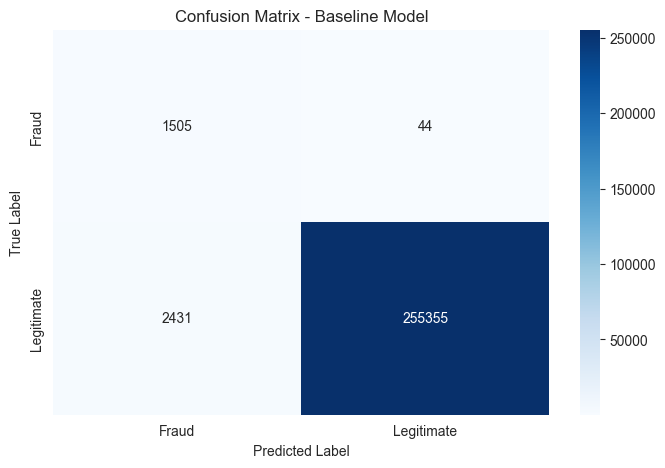

In [43]:
# Confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fraud', 'Legitimate'], yticklabels=['Fraud', 'Legitimate'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

Hyperparameter Tuning using Optuna

In [45]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss'
    }

    m = XGBClassifier(**params)
    p = Pipeline([('prep', preprocessor), ('model', m)])
    score = cross_val_score(p, X_train, y_train, scoring='roc_auc', cv=3).mean()
    return score

study = optuna.create_study(direction='maximize', study_name='fraud_detection')
study.optimize(objective, n_trials=10, show_progress_bar=True)

best_params = study.best_params


[I 2026-01-01 07:41:57,150] A new study created in memory with name: fraud_detection
Best trial: 0. Best value: 0.997509:  10%|█         | 1/10 [00:36<05:32, 36.94s/it]

[I 2026-01-01 07:42:34,091] Trial 0 finished with value: 0.9975089139177119 and parameters: {'n_estimators': 463, 'max_depth': 5, 'learning_rate': 0.01787386509644734, 'subsample': 0.8368055193426831, 'colsample_bytree': 0.8074728308754905}. Best is trial 0 with value: 0.9975089139177119.


Best trial: 1. Best value: 0.998294:  20%|██        | 2/10 [01:30<06:15, 46.92s/it]

[I 2026-01-01 07:43:27,994] Trial 1 finished with value: 0.9982944711313425 and parameters: {'n_estimators': 418, 'max_depth': 9, 'learning_rate': 0.05857266644619758, 'subsample': 0.9983248998451387, 'colsample_bytree': 0.9688951026314983}. Best is trial 1 with value: 0.9982944711313425.


Best trial: 1. Best value: 0.998294:  30%|███       | 3/10 [02:02<04:40, 40.02s/it]

[I 2026-01-01 07:43:59,800] Trial 2 finished with value: 0.9979698273775597 and parameters: {'n_estimators': 229, 'max_depth': 9, 'learning_rate': 0.11456900684711749, 'subsample': 0.6175605318787524, 'colsample_bytree': 0.9484311624230397}. Best is trial 1 with value: 0.9982944711313425.


Best trial: 3. Best value: 0.998529:  40%|████      | 4/10 [02:55<04:31, 45.19s/it]

[I 2026-01-01 07:44:52,920] Trial 3 finished with value: 0.9985287239227528 and parameters: {'n_estimators': 522, 'max_depth': 7, 'learning_rate': 0.057425408330342965, 'subsample': 0.6866514115037052, 'colsample_bytree': 0.7530663067052314}. Best is trial 3 with value: 0.9985287239227528.


Best trial: 3. Best value: 0.998529:  50%|█████     | 5/10 [03:28<03:23, 40.80s/it]

[I 2026-01-01 07:45:25,930] Trial 4 finished with value: 0.9983054934691383 and parameters: {'n_estimators': 552, 'max_depth': 3, 'learning_rate': 0.19915544381024441, 'subsample': 0.94884092240207, 'colsample_bytree': 0.9006489491882265}. Best is trial 3 with value: 0.9985287239227528.


Best trial: 3. Best value: 0.998529:  60%|██████    | 6/10 [04:24<03:03, 45.83s/it]

[I 2026-01-01 07:46:21,513] Trial 5 finished with value: 0.9984820773519095 and parameters: {'n_estimators': 448, 'max_depth': 9, 'learning_rate': 0.12287632414507298, 'subsample': 0.8294244495910048, 'colsample_bytree': 0.704111317609141}. Best is trial 3 with value: 0.9985287239227528.


Best trial: 3. Best value: 0.998529:  70%|███████   | 7/10 [05:04<02:11, 43.88s/it]

[I 2026-01-01 07:47:01,396] Trial 6 finished with value: 0.998339735197888 and parameters: {'n_estimators': 366, 'max_depth': 7, 'learning_rate': 0.028372688907418314, 'subsample': 0.8550680971090852, 'colsample_bytree': 0.769626709944313}. Best is trial 3 with value: 0.9985287239227528.


Best trial: 3. Best value: 0.998529:  80%|████████  | 8/10 [05:39<01:22, 41.23s/it]

[I 2026-01-01 07:47:36,940] Trial 7 finished with value: 0.9980526852936524 and parameters: {'n_estimators': 239, 'max_depth': 10, 'learning_rate': 0.1410375764949715, 'subsample': 0.6878657177042035, 'colsample_bytree': 0.9558877808003767}. Best is trial 3 with value: 0.9985287239227528.


Best trial: 3. Best value: 0.998529:  90%|█████████ | 9/10 [06:21<00:41, 41.24s/it]

[I 2026-01-01 07:48:18,199] Trial 8 finished with value: 0.9985275014883443 and parameters: {'n_estimators': 465, 'max_depth': 6, 'learning_rate': 0.05213450610838288, 'subsample': 0.8218228208433576, 'colsample_bytree': 0.8661549167869884}. Best is trial 3 with value: 0.9985287239227528.


Best trial: 3. Best value: 0.998529: 100%|██████████| 10/10 [06:54<00:00, 41.47s/it]

[I 2026-01-01 07:48:51,877] Trial 9 finished with value: 0.9947291291722937 and parameters: {'n_estimators': 506, 'max_depth': 3, 'learning_rate': 0.022960147880013486, 'subsample': 0.672514945693523, 'colsample_bytree': 0.8975391693540653}. Best is trial 3 with value: 0.9985287239227528.


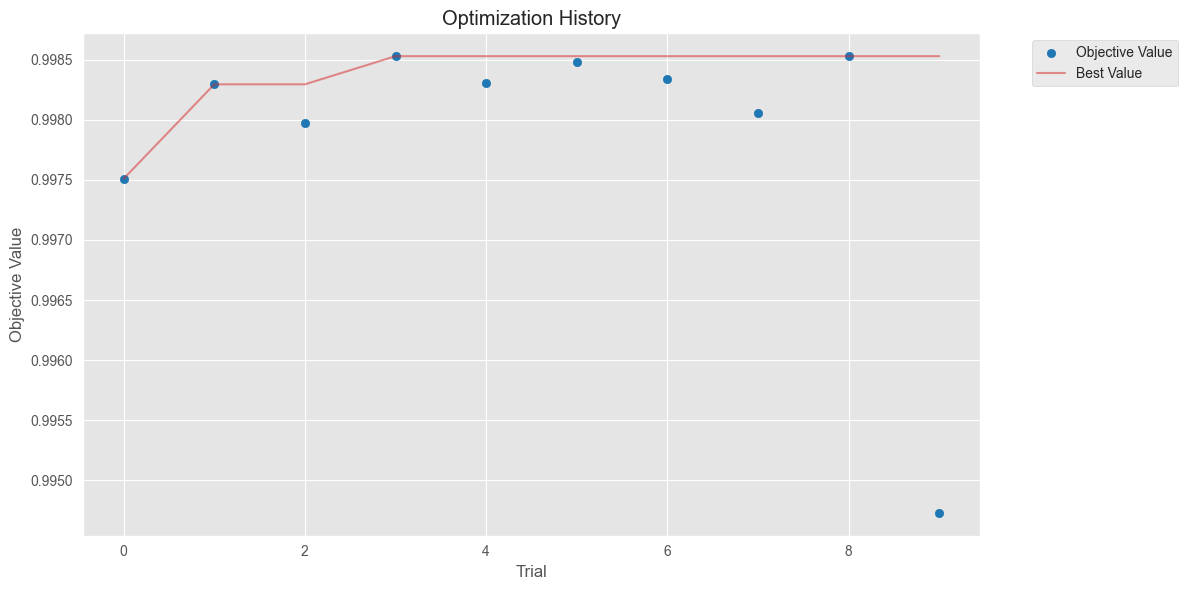

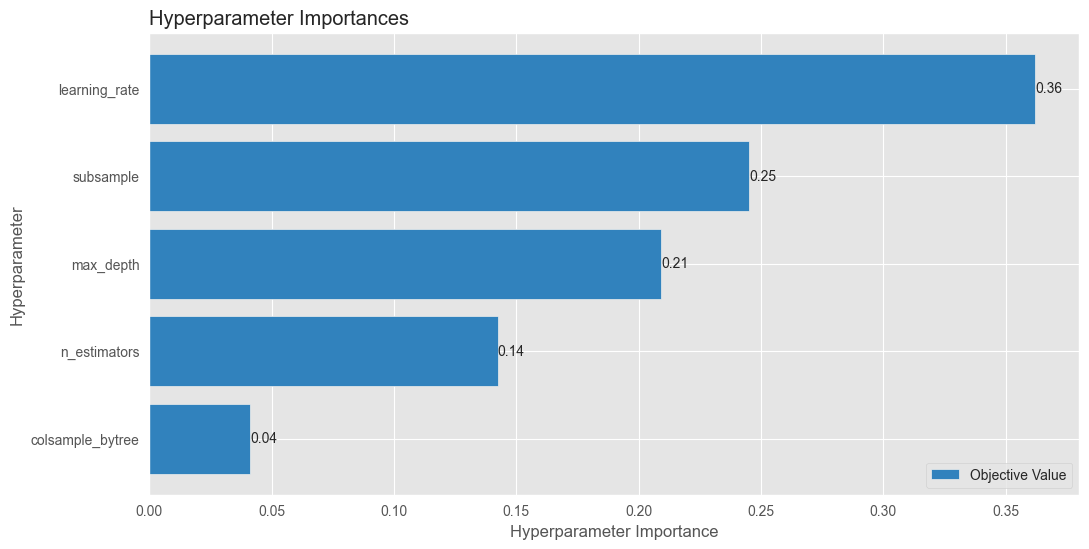

In [46]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

Final Optimised Model

In [47]:
final_model = XGBClassifier(**best_params)
final_pipeline = Pipeline([('prep', preprocessor), ('model', final_model)])
final_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('bin', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers conta

In [48]:
y_pred_final = final_pipeline.predict(X_test)
y_prob_final = final_pipeline.predict_proba(X_test)[:, 1]

Final Model Evaluation on (Threshold = 0.5)

In [49]:
print(classification_report(y_test, y_pred_final, target_names=['Legitimate', 'Fraud']))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob_final))

              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    257786
       Fraud       0.95      0.83      0.88      1549

    accuracy                           1.00    259335
   macro avg       0.97      0.91      0.94    259335
weighted avg       1.00      1.00      1.00    259335

Test ROC AUC: 0.9989300006260291


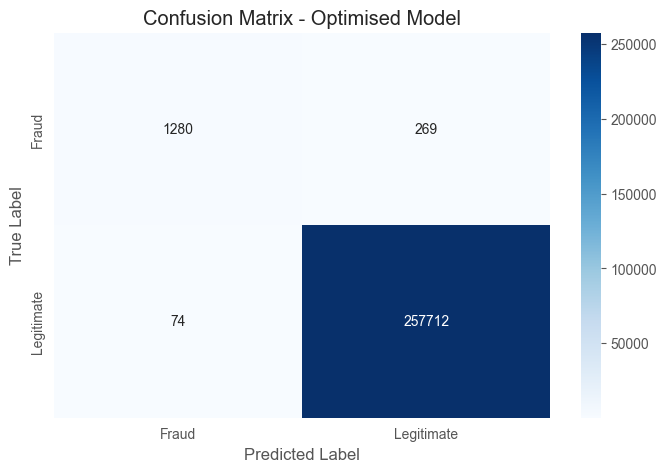

In [50]:
# Confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred_final, labels=[1, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fraud', 'Legitimate'], yticklabels=['Fraud', 'Legitimate'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Optimised Model')
plt.show()


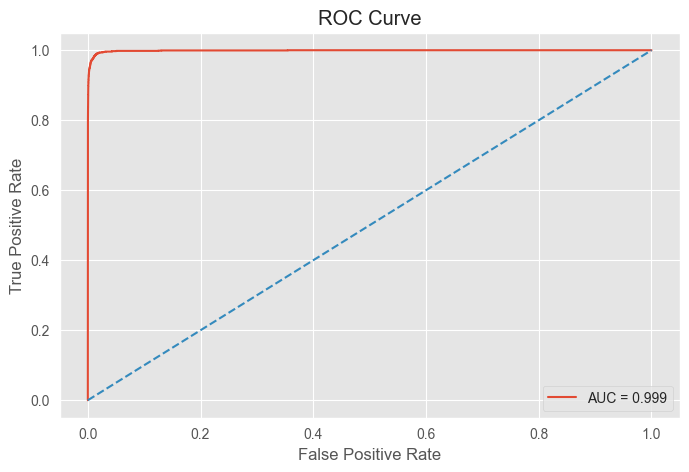

In [51]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

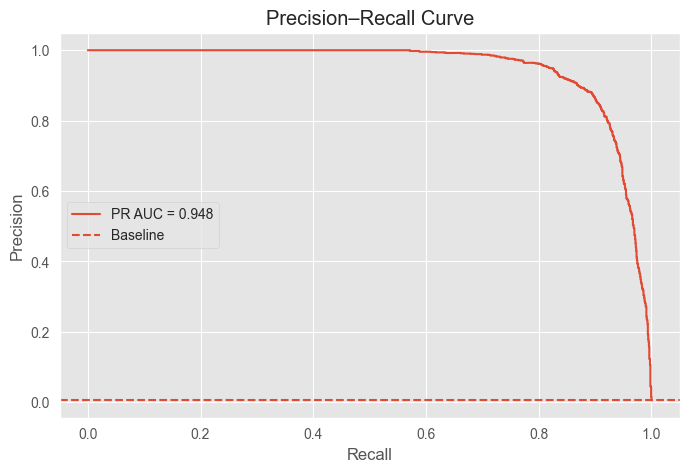

In [52]:
#Precision–Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_final)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.axhline(y=y_test.mean(), linestyle='--', label="Baseline")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

Business Optimised threshold selection

In [53]:
# Business assumptions ($ — units don't matter, only ratios)
COST_FALSE_POSITIVE = 5      # cost of investigating a legitimate transaction
COST_FALSE_NEGATIVE = 500   # cost of missing a fraud (chargeback, fees, customer loss)
BENEFIT_TRUE_POSITIVE = 500 # fraud prevented
BENEFIT_TRUE_NEGATIVE = 0


In [54]:

def calculate_profit(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    profit = (
        tp * BENEFIT_TRUE_POSITIVE + tn * BENEFIT_TRUE_NEGATIVE - fp * COST_FALSE_POSITIVE - fn * COST_FALSE_NEGATIVE
    )
    return profit, (tp, fp, fn, tn)


In [55]:
def find_optimal_threshold_vectorized(y_true, y_prob):
    """Vectorized threshold optimization - avoids slow loop"""
    y_true = y_true.values if hasattr(y_true, 'values') else y_true
    
    # Sort by probability (descending)
    sorted_idx = np.argsort(y_prob)[::-1]
    y_sorted = y_true[sorted_idx]
    prob_sorted = y_prob[sorted_idx]
    
    # Vectorized confusion matrix components
    tp = np.cumsum(y_sorted)  # True positives
    fp = np.arange(1, len(y_sorted) + 1) - tp  # False positives
    fn = y_sorted.sum() - tp  # False negatives
    tn = len(y_sorted) - y_sorted.sum() - fp  # True negatives
    
    # Calculate profit for ALL thresholds at once (no loop!)
    profits = (tp * BENEFIT_TRUE_POSITIVE + tn * BENEFIT_TRUE_NEGATIVE - fp * COST_FALSE_POSITIVE - fn * COST_FALSE_NEGATIVE)
    
    # Find optimal
    optimal_idx = np.argmax(profits)
    optimal_threshold = prob_sorted[optimal_idx]
    max_profit = profits[optimal_idx]
    
    return optimal_threshold, max_profit, (int(tp[optimal_idx]), int(fp[optimal_idx]), int(fn[optimal_idx]), int(tn[optimal_idx])), profits, prob_sorted


In [56]:
optimal_threshold, max_profit, (tp, fp, fn, tn), profits, prob_sorted = find_optimal_threshold_vectorized(
    y_test, y_prob_final
)

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"Maximum Expected Profit: ${max_profit:,.0f}")
print(f"\nConfusion Matrix:")
print(f"  TP: {tp:,} | FP: {fp:,}")
print(f"  FN: {fn:,} | TN: {tn:,}")
print(f"\n(Default threshold 0.5 would give: ${calculate_profit(y_test, y_pred_final)[0]:,.0f})")


Optimal Threshold: 0.0032
Maximum Expected Profit: $739,850

Confusion Matrix:
  TP: 1,535 | FP: 4,130
  FN: 14 | TN: 253,656

(Default threshold 0.5 would give: $505,130)


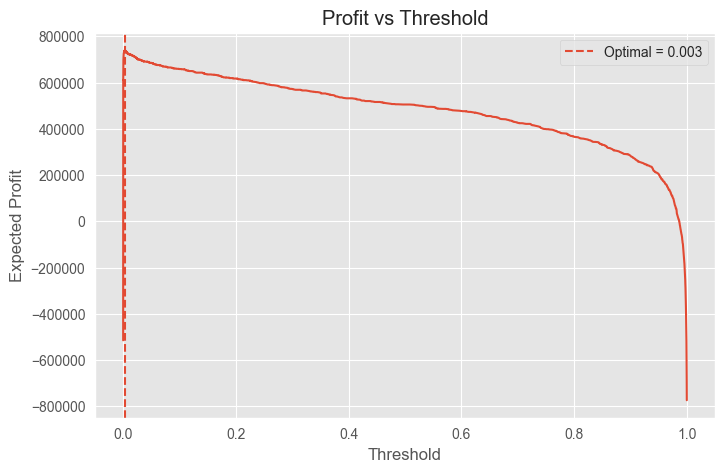

In [57]:
# Visualize profit vs threshold
plt.figure(figsize=(8,5))
plt.plot(prob_sorted, profits)
plt.axvline(optimal_threshold, linestyle='--', label=f'Optimal = {optimal_threshold:.3f}')
plt.xlabel("Threshold")
plt.ylabel("Expected Profit")
plt.title("Profit vs Threshold")
plt.legend()
plt.show()


In [58]:
optimal_preds = (y_prob_final >= optimal_threshold).astype(int)

profit, (tp, fp, fn, tn) = calculate_profit(y_test, optimal_preds)

print(f"TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f"Precision: {tp/(tp+fp):.3f}")
print(f"Recall:    {tp/(tp+fn):.3f}")
print(f"Net Profit: ${profit:,.0f}")


TP=1535  FP=4130  FN=14  TN=253656
Precision: 0.271
Recall:    0.991
Net Profit: $739,850


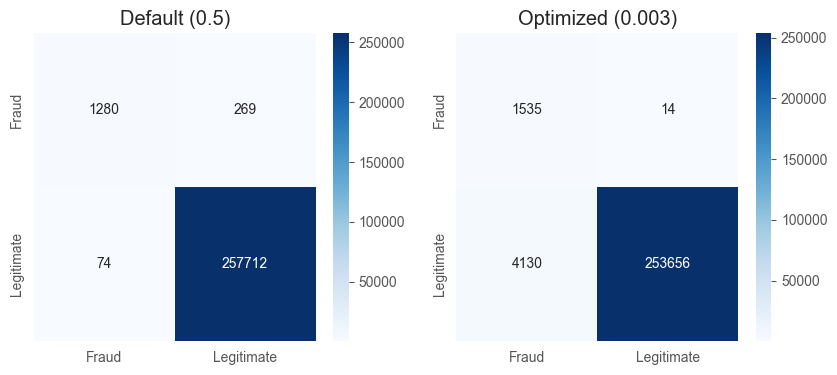

In [59]:
#Compare default vs optimized threshold
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(confusion_matrix(y_test, y_pred_final, labels=[1,0]), annot=True, fmt='d', cmap='Blues', xticklabels=['Fraud', 'Legitimate'], yticklabels=['Fraud', 'Legitimate'], ax=ax[0])
ax[0].set_title("Default (0.5)")

sns.heatmap(confusion_matrix(y_test, optimal_preds, labels=[1,0]), annot=True, fmt='d', cmap='Blues', xticklabels=['Fraud', 'Legitimate'], yticklabels=['Fraud', 'Legitimate'], ax=ax[1])
ax[1].set_title(f"Optimized ({optimal_threshold:.3f})")

plt.show()

SHAP

In [60]:
# Prepare data for SHAP
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [61]:
# Sample for efficiency
sample_size = min(1000, len(X_train_processed))
sample_indices = np.random.choice(len(X_train_processed), sample_size, replace=False)
X_sample = X_train_processed[sample_indices]

In [62]:
# Create SHAP explainer with background data
explainer = shap.TreeExplainer(
    final_pipeline.named_steps['model'],
    data=X_sample,                   # background data
    model_output="probability"       # explain probability directly
)


In [63]:
# Extract SHAP values
shap_values = explainer(X_sample)

 98%|===================| 982/1000 [00:31<00:00]        

In [64]:
shap_values.feature_names = feature_names
shap_values.data = X_sample

In [65]:
X_test.iloc[[0]]


,gender,city_pop,hour,dayofweek,is_weekend,amt_log,user_amt_mean,user_amt_std,amt_zscore,time_since_last_txn,txns_last_1hr,txns_last_10min,geo_distance,merchant_freq,city_freq,job_freq,state_freq,category_freq
649168,F,73,18,3,0,4.110382,74.903698,644.269053,-0.023179,53257.0,0,0,127.430391,0.001378,0.001581,0.001963,0.018638,0.06623


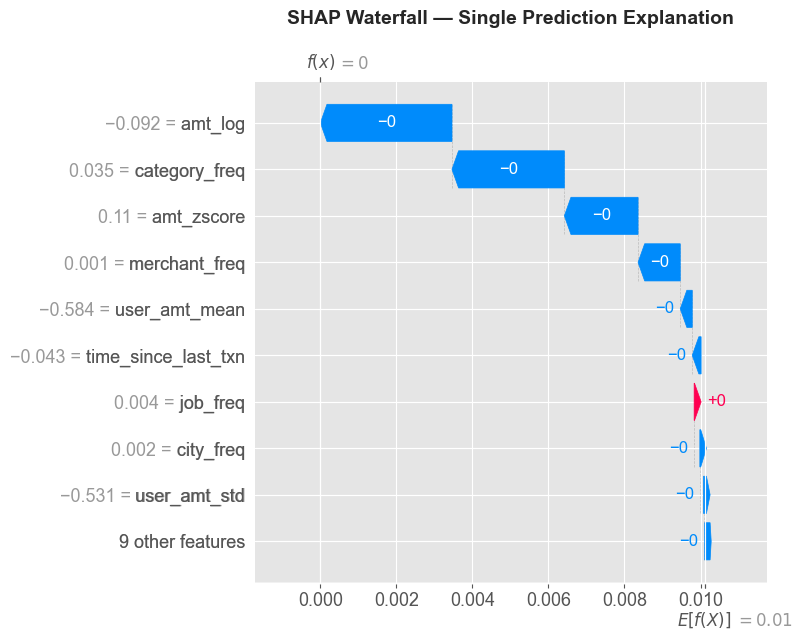

In [70]:
# SHAP Waterfall Plot
shap.plots.waterfall(shap_values[180], show=False)
plt.title("SHAP Waterfall — Single Prediction Explanation", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

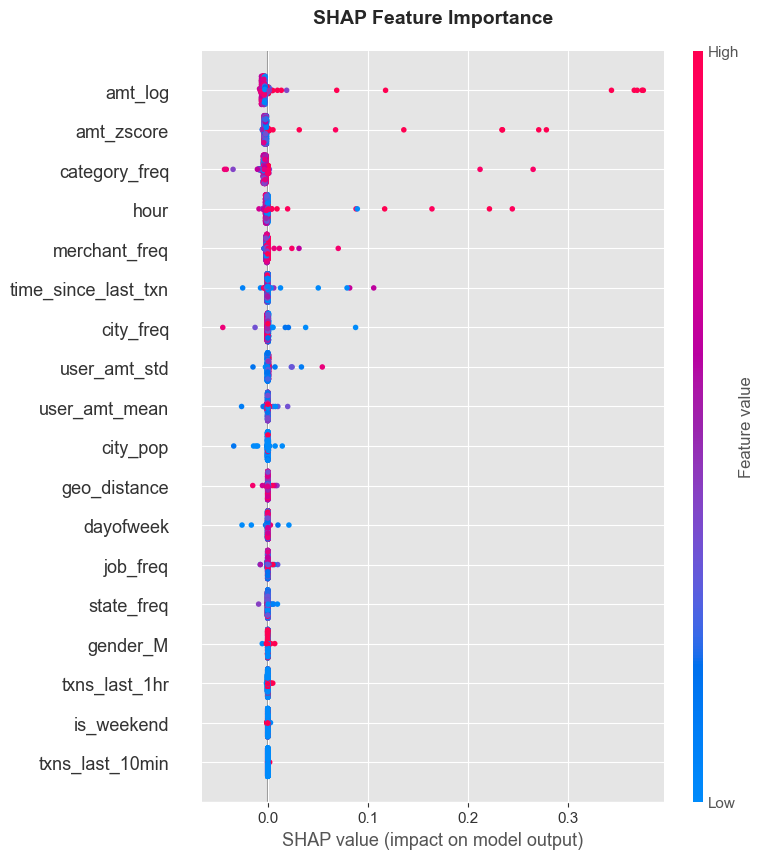

In [67]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

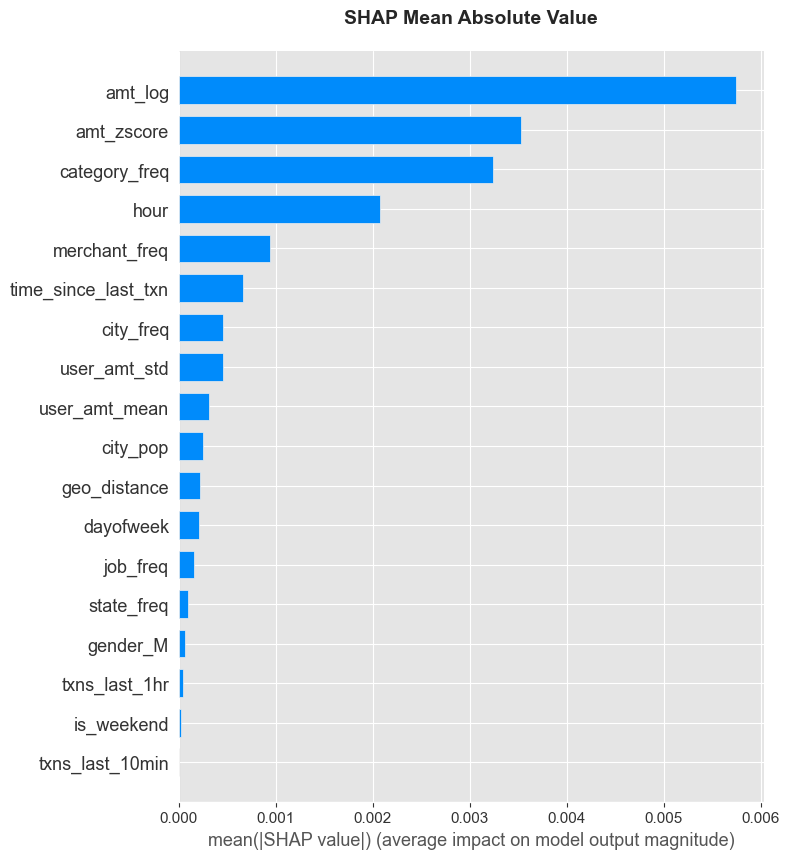

In [68]:
# SHAP Bar Plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type='bar', show=False)
plt.title("SHAP Mean Absolute Value", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


Saving Model Artifacts

In [69]:
# Save the trained pipeline
with open('fraud_model_pipeline.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)
print("✓ Saved: fraud_model_pipeline.pkl")

# Save the optimal threshold
with open('optimal_threshold.pkl', 'wb') as f:
    pickle.dump(optimal_threshold, f)
print("✓ Saved: optimal_threshold.pkl")

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✓ Saved: feature_names.pkl")

# Save business parameters
business_params = {
    'optimal_threshold': optimal_threshold,
    'cost_fp': COST_FALSE_POSITIVE,
    'cost_fn': COST_FALSE_NEGATIVE,
    'benefit_tp': BENEFIT_TRUE_POSITIVE,
    'benefit_tn': BENEFIT_TRUE_NEGATIVE,
    'scale_pos_weight': scale_pos_weight,
    'max_profit': max_profit
}

with open('business_params.pkl', 'wb') as f:
    pickle.dump(business_params, f)
print("✓ Saved: business_params.pkl")

print("ALL ARTIFACTS SAVED SUCCESSFULLY!")

✓ Saved: fraud_model_pipeline.pkl
✓ Saved: optimal_threshold.pkl
✓ Saved: feature_names.pkl
✓ Saved: business_params.pkl
ALL ARTIFACTS SAVED SUCCESSFULLY!
